In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
import scipy.stats as st
import pickle


from candlestick.candlestick import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from getstock import *

matplotlib.rcParams['figure.figsize'] = (14, 6)

%load_ext autoreload
%autoreload 2

#### Load data and format it

+ fx data from https://www.histdata.com/download-free-forex-historical-data/?/metatrader/1-minute-bar-quotes/USDTRY

In [2]:
df_ohlc = pd.read_csv('DAT_MT_USDTRY_M1_201910.csv')
df_ohlc.index = pd.to_datetime(df_ohlc.day)+ pd.to_timedelta(df_ohlc.time.apply(lambda x:x+':00'),unit='minute')
df_ohlc = df_ohlc[['open','high','low','close']]

In [3]:
# df_ohlc = pd.read_csv('NASDAQ_AAPL_5min.csv')
# df_ohlc.index = pd.to_datetime(df_ohlc.date,format="%Y%m%d%H%M")
# df_ohlc = df_ohlc[['open','high','low','close']]

In [4]:
# df_ohlc = pd.read_csv('IBM.1min.TradesAndQuotes.20160128.csv')

# df_ohlc =  df_ohlc[['open','high','low','close']]
# df_ohlc.T

#### Plot Candlestick chart for a short time

In [213]:
df_to_plot = df_ohlc.iloc[:800]
fig = go.Figure(data=[go.Candlestick(x=df_to_plot.index,
                open=df_to_plot['open'],
                high=df_to_plot['high'],
                low=df_to_plot['low'],
                close=df_to_plot['close'])])
fig.show()

#### Define Functions to:
+ Label intervals with returns
+ Detect patterns
+ Make statistics on them

In [220]:
def label(df_candles,n_shift):
    """
    label returns n_shift periods before them
    """
    df_candles['returns'+str(n_shift)] = df_candles['close'].shift(-n_shift)/df_candles['close']
    return df_candles

def get_candlestick_detection_function(pattern):
    return getattr(getattr(__import__('candlestick.candlestick'), 'candlestick'),pattern)

def detect_patterns(patterns_list,df_bars):
    df_bars = df_bars.copy()
    for p in patterns_list:
        func = get_candlestick_detection_function(p)
        df_bars = func(df_bars)
    return df_bars


def make_stats(patterns_list,df_bars,returns_name,confidence=0.95,symbol=None,export=True):
    df = pd.DataFrame(index=['mean','CI','count','std','significant'])
    ret = (df_bars[returns_name]-1.)*100
    for p in patterns_list:
        p_list = p.split('_')
        p_modified = ''.join(list(map(lambda x: x[0].upper()+x[1:],p_list)))
        ret_pattern = ret[df_bars[p_modified]==True]
        mean= ret_pattern.mean()
        std = ret_pattern.std()
        count = ret_pattern.count()
        CI = std*st.t.ppf(0.5*(1+confidence),count)/np.sqrt(count)
        significant = (mean+CI)*(mean-CI)>0.
        df[p_modified] = [mean,CI,count,std,significant]
    if export: 
        n_shift = int(returns_name.split('returns')[-1])
        df_stats =df.T.copy()
        df_stats['n_shift'] = n_shift
        df_stats['confidence'] = confidence
        df_stats['symbol'] =symbol
        df_significant = df_stats[df_stats.significant==True]
        complete_results_significant(df_significant)

        complete_results_all(symbol,n_shift,df_stats)
    return df 

def label_multi(n_shift_list,df_bars):
    df_bars = df_bars.copy()
    for n in n_shift_list:
        df_bars = label(df_bars,n)
    return df_bars



def dump_pickle(obj, path: str, protocol=pickle.HIGHEST_PROTOCOL):
    """
    :param obj: obj to pickle
    :param path: path for the dump MUST BE with no suffix this function will automatically add '.pickle' in the name
    :param protocol: protocol for the pickling
    """
    f = open(path + '.pickle', 'wb')
    try:
        pickle.dump(obj, f, protocol=protocol)
    except Exception as e:
        raise e
    finally:
        f.close()


def load_pickle(path: str):
    """
    Unpickles an objects, returns it and logs before and after the loading
    :param path: str: path for the file to load
    :return: object of the pickle
    """
    # ensuring the file ends in '.pickle'
    path = path.replace('.pickle', '') + '.pickle'

    print('Unpickling data at {}'.format(path))
    f = open(path, 'rb')
    res = pickle.load(f)
    f.close()
    print('Data unpickled, type: {}'.format(res.__class__))
    return res

def complete_results_all(symbol,n_shift_returns,df_stats):
    path = 'stats_results'
    try:
        dic = load_pickle(path)
    except:
        dic = {}
    
    dic_symbol = dic.get(symbol,{})
    dic_symbol.update({n_shift_returns:df_stats})
    dic.update({symbol:dic_symbol})
    dump_pickle(dic,path)
    
def complete_results_significant(df_stats):
    path = 'stats_results_significant'
    try:
        df = load_pickle(path)
    except:
        df = pd.DataFrame()
    df = pd.concat([df,df_stats])
    df = df.drop_duplicates()

    dump_pickle(df,path)

### Find the list of supported patterns

In [215]:
patterns_list = list(map(lambda x :x.replace('.py',''), os.listdir('candlestick/patterns')))
patterns_list.remove('candlestick_finder')
patterns_list.remove('__pycache__')
patterns_list

['bearish_engulfing',
 'bearish_harami',
 'bullish_engulfing',
 'bullish_harami',
 'dark_cloud_cover',
 'doji',
 'doji_star',
 'dragonfly_doji',
 'evening_star',
 'evening_star_doji',
 'gravestone_doji',
 'hammer',
 'hanging_man',
 'inverted_hammer',
 'morning_star',
 'morning_star_doji',
 'piercing_pattern',
 'rain_drop',
 'rain_drop_doji',
 'shooting_star',
 'star']

#### Run all patterns detection

In [216]:
df_bars = detect_patterns(patterns_list,df_ohlc)

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\doji.py:17: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\doji_star.py:25: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\dragonfly_doji.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\evening_star_doji.py:30: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\gravestone_doji.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\morning_star_doji.py:30: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candles

#### Label returns for different shifts

In [217]:
df_bars = label_multi([1,2,3,4,5,8,10,20,30,60],df_bars)

In [218]:
df_bars.tail()

,open,high,low,close,BearishEngulfing,BearishHarami,BullishEngulfing,BullishHarami,DarkCloudCover,Doji,...,returns1,returns2,returns3,returns4,returns5,returns8,returns10,returns20,returns30,returns60
2019-10-18 16:32:00,5.79229,5.79254,5.79063,5.79254,False,False,False,False,False,False,...,0.999651,0.999653,0.999651,0.999653,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-18 16:33:00,5.79244,5.79244,5.79041,5.79052,False,False,False,False,False,False,...,1.000002,1.000000,1.000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-18 16:34:00,5.79052,5.79053,5.79052,5.79053,False,False,False,True,False,False,...,0.999998,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-18 16:35:00,5.79053,5.79053,5.79052,5.79052,False,False,False,False,False,False,...,1.000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-18 16:36:00,5.79053,5.79053,5.79053,5.79053,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Statistics on the returns based on the candlestick pattern

In [231]:
df = make_stats(patterns_list,df_bars,'returns1',confidence=0.95,symbol='USDTRY',export=False)
df.T

,mean,CI,count,std,significant
BearishEngulfing,0.00078054,0.00178708,1111,0.0303585,False
BearishHarami,0.000568329,0.00140584,1247,0.0253047,False
BullishEngulfing,-0.00192255,0.00128031,1055,0.021193,True
BullishHarami,0.00109501,0.00147244,1208,0.0260848,False
DarkCloudCover,0.0073548,0.0139901,22,0.031641,False
Doji,0.000266345,0.00174137,971,0.027651,False
DojiStar,0.00623877,0.00854495,44,0.0281243,False
DragonflyDoji,-0.00327031,0.00251362,223,0.0190476,True
EveningStar,0.000663326,0.00331333,101,0.0167858,False
EveningStarDoji,0.00152661,NaN,1,NaN,False


#### retrieve all results and see the significant ones

In [221]:
load_pickle('stats_results_significant.pickle')

Unpickling data at stats_results_significant.pickle
Data unpickled, type: <class 'pandas.core.frame.DataFrame'>


,mean,CI,count,std,significant,n_shift,confidence,symbol
BearishEngulfing,-0.006353,0.00634445,1760,0.135707,True,60,0.95,USDTRY
BearishHarami,-0.0081288,0.00644203,1900,0.143177,True,60,0.95,USDTRY
BullishEngulfing,-0.0106974,0.00647481,1621,0.132906,True,60,0.95,USDTRY
Hammer,-0.0166817,0.0162519,201,0.116851,True,60,0.95,USDTRY
InvertedHammer,0.0411882,0.0298934,121,0.166094,True,60,0.95,USDTRY
ShootingStar,0.011363,0.0112362,345,0.106109,True,60,0.95,USDTRY
BullishEngulfing,-0.00598127,0.00455705,1623,0.0935989,True,30,0.95,USDTRY
InvertedHammer,0.0222229,0.019971,121,0.110963,True,30,0.95,USDTRY
BullishEngulfing,-0.00181328,0.00173779,1624,0.0357042,True,3,0.95,USDTRY
InvertedHammer,0.0106401,0.00660995,121,0.0367263,True,3,0.95,USDTRY


#### Visualize the distribution of the returns for a specific pattern 

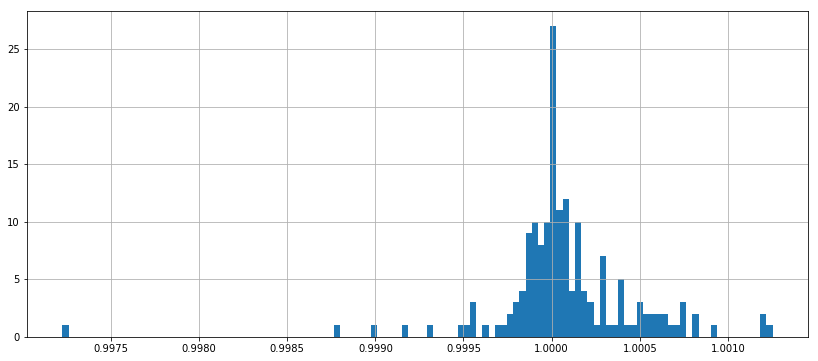

In [240]:
df_bars['returns2'][df_bars['InvertedHammer']==True].hist(bins=115)

#### Resample to larger windows

In [ ]:
df_bars = df_bars.resample('2min').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
